In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score, recall_score, precision_score, f1_score, roc_curve, confusion_matrix, precision_recall_curve

# Visual Settings for Scientific Reporting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [2]:
# Load the Final Results from Notebook 06
print("Loading Ensemble Results...")
try:
    # This file contains y_true and the predictions from ALL models
    df = pd.read_parquet('../outputs/ensemble_results.parquet')
    y_true = df['y_true'].values
    print(f"✅ Successfully loaded {len(df)} validation samples.")
    print("Columns found:", df.columns.tolist())
except FileNotFoundError:
    print("❌ Error: '../outputs/ensemble_results.parquet' not found.")
    print("Please run Notebook 06 (Generate Ensemble Predictions) first.")

Loading Ensemble Results...
✅ Successfully loaded 118108 validation samples.
Columns found: ['y_true', 'pred_lgbm', 'pred_tabnet', 'pred_mtl', 'pred_ensemble']


In [9]:
# --- METRICS TABLE ---
# We calculate key metrics for every model to see who wins in each category

def get_metrics(y_true, y_pred, name, thresh=0.5):
    # Convert probabilities to binary predictions
    y_bin = (y_pred > thresh).astype(int)
    
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_bin),
        'AUC': roc_auc_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_bin),
        'Precision': precision_score(y_true, y_bin),
        'F1 Score': f1_score(y_true, y_bin)
    }

# Compute metrics for all 4 distinct stages of your project
metrics_list = [
    get_metrics(y_true, df['pred_lgbm'], 'LightGBM (Tree Baseline)'),
    get_metrics(y_true, df['pred_tabnet'], 'Standard TabNet (Neural Baseline)'),
    get_metrics(y_true, df['pred_mtl'], 'Asymmetric MTL (Custom Arch)'),
    get_metrics(y_true, df['pred_ensemble'], 'Stacked Ensemble (Final)')
]

# Create a clean DataFrame
res_df = pd.DataFrame(metrics_list).set_index('Model')

# Display with a color gradient to highlight best scores
print("\n--- Final Performance Comparison ---")
display(res_df.style.background_gradient(cmap='Greens', subset=['Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score']))

# Print specific improvement of Ensemble over LightGBM
lgbm_auc = res_df.loc['LightGBM (Tree Baseline)', 'AUC']
ens_auc = res_df.loc['Stacked Ensemble (Final)', 'AUC']
improvement = ((ens_auc - lgbm_auc) / lgbm_auc) * 100

print(f"Improvement over Single Best Model: {improvement:+.3f}%")


--- Final Performance Comparison ---


,Accuracy,AUC,Recall,Precision,F1 Score
Model,,,,,
LightGBM (Tree Baseline),0.986843,0.985166,0.635827,0.972160,0.768819
Standard TabNet (Neural Baseline),0.972466,0.872602,0.236467,0.865766,0.371473
Asymmetric MTL (Custom Arch),0.966488,0.825562,0.056594,0.649718,0.104120
Stacked Ensemble (Final),0.989518,0.985276,0.751722,0.930268,0.831519


Improvement over Single Best Model: +0.011%


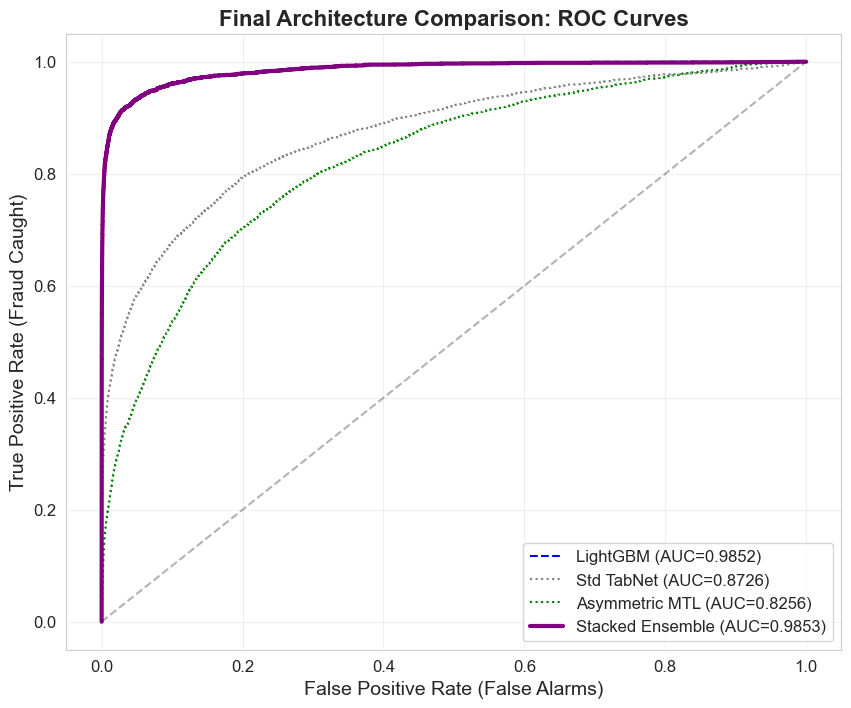

In [4]:
# --- ROC CURVE COMPARISON ---
# Visual proof that the Ensemble (Purple) sits above or equals the others

plt.figure(figsize=(10, 8))

models = [
    ('LightGBM', df['pred_lgbm'], '--', 1.5, 'blue'),
    ('Std TabNet', df['pred_tabnet'], ':', 1.5, 'gray'),
    ('Asymmetric MTL', df['pred_mtl'], ':', 1.5, 'green'),
    ('Stacked Ensemble', df['pred_ensemble'], '-', 3.0, 'purple') # Thicker line for the winner
]

for name, preds, style, width, color in models:
    fpr, tpr, _ = roc_curve(y_true, preds)
    auc_val = roc_auc_score(y_true, preds)
    plt.plot(fpr, tpr, linestyle=style, linewidth=width, color=color, label=f"{name} (AUC={auc_val:.4f})")

# Add diagonal random guess line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.title('Final Architecture Comparison: ROC Curves', fontweight='bold')
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Fraud Caught)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

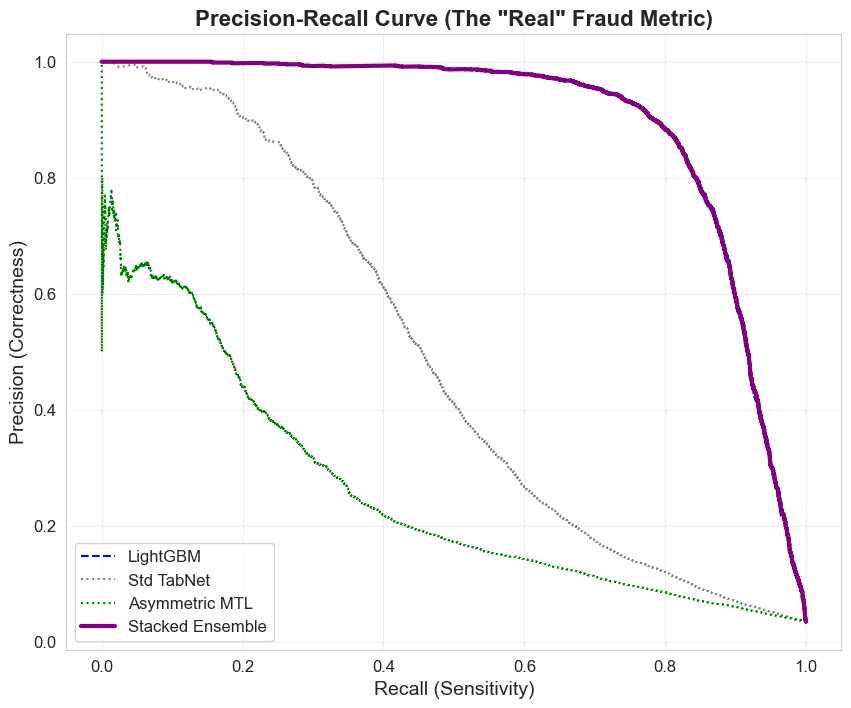

In [5]:
# --- PRECISION-RECALL CURVE ---
# Crucial for Fraud Detection (Highly Imbalanced Data)
# This shows how many false alarms we get for every fraud we catch

plt.figure(figsize=(10, 8))

for name, preds, style, width, color in models:
    precision, recall, _ = precision_recall_curve(y_true, preds)
    plt.plot(recall, precision, linestyle=style, linewidth=width, color=color, label=name)

plt.title('Precision-Recall Curve (The "Real" Fraud Metric)', fontweight='bold')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Correctness)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

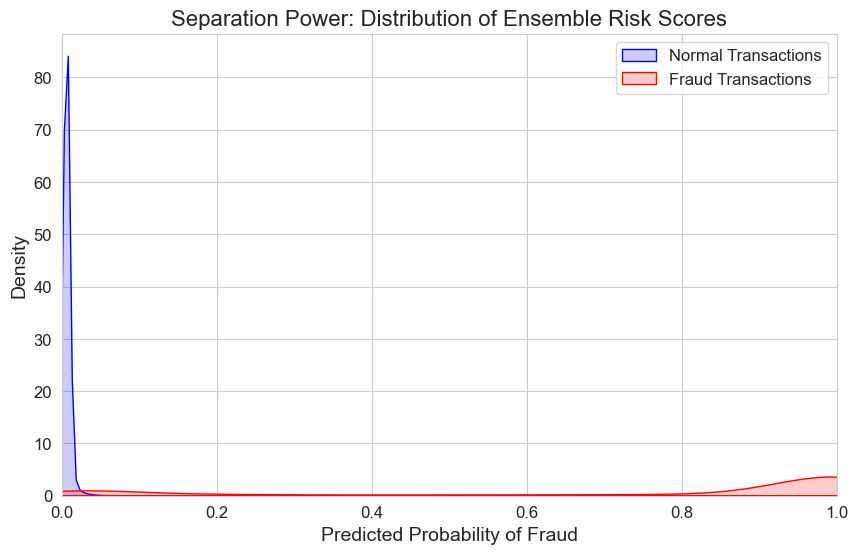

In [6]:
# --- SCORE DISTRIBUTION ---
# Why is the model so good? Let's see how well it separates the two classes.
# Ideally, "Normal" is pushed to 0.0 and "Fraud" is pushed to 1.0.

plt.figure(figsize=(10, 6))
sns.kdeplot(df[y_true == 0]['pred_ensemble'], label='Normal Transactions', fill=True, color='blue', alpha=0.2)
sns.kdeplot(df[y_true == 1]['pred_ensemble'], label='Fraud Transactions', fill=True, color='red', alpha=0.2)

plt.title('Separation Power: Distribution of Ensemble Risk Scores')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.legend()
plt.show()

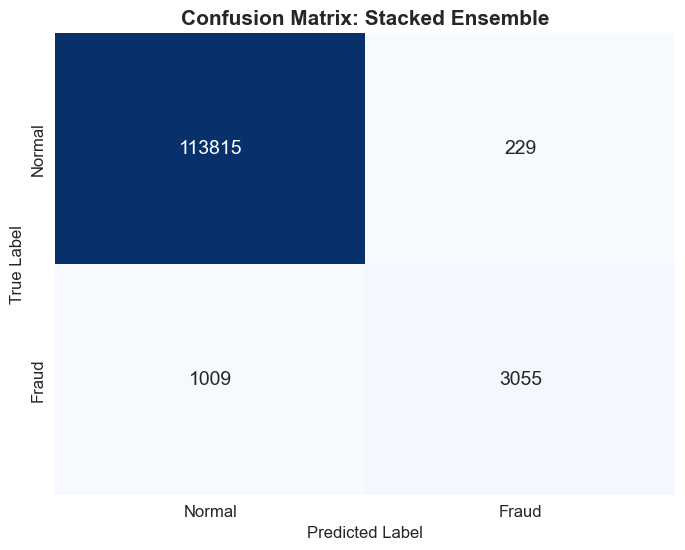

In [7]:
# Cell 6: Confusion Matrix & Classification Report (Stacked Ensemble)
# 1. Thresholding
# Standard is 0.5, but you can lower it (e.g., 0.3) to catch more fraud
threshold = 0.5
final_preds_binary = (df['pred_ensemble'] > threshold).astype(int)

# 2. Plot Matrix
cm = confusion_matrix(y_true, final_preds_binary)

plt.figure(figsize=(8, 6))
# 'fmt="d"' formats the numbers as integers (no scientific notation)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})

plt.title('Confusion Matrix: Stacked Ensemble', fontsize=15, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
plt.show()